# Emotion_Recognition For Chatbot 

In [3]:
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

## Exploring the data

In [4]:
data_directory ='/home/praveen/Desktop/Projects/technocolab_project_2/emotion_recognition/input/fer2013.csv'

In [5]:
data_df = pd.read_csv(data_directory)
data_df.head(4)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training


In [6]:
print(len(data_df))

35887


In [7]:
print(data_df['Usage'].nunique())
print(data_df['Usage'].unique())

3
['Training' 'PublicTest' 'PrivateTest']


In [8]:
print(len(data_df[data_df['Usage']=='Training']))
print(len(data_df[data_df['Usage']=='PublicTest']))
print(len(data_df[data_df['Usage']=='PrivateTest']))

28709
3589
3589


## As per the dataset these are the available emotions and their numerical values

In [9]:
Labels = {
    0:'Angry',
    1:'Disgust',
    2:'Fear',
    3:'Happy',
    4:'Sad',
    5:'Surprise',
    6:'Neutral'
}
Labels

{0: 'Angry',
 1: 'Disgust',
 2: 'Fear',
 3: 'Happy',
 4: 'Sad',
 5: 'Surprise',
 6: 'Neutral'}

## Train, Valid, Test Data Frames

In [10]:
train_df = data_df[data_df['Usage']=='Training']
valid_df = data_df[data_df['Usage']=='PublicTest']
test_df = data_df[data_df['Usage']=='PrivateTest']
print(train_df.head())
print(valid_df.head(-1))

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
       emotion                                             pixels       Usage
28709        0  254 254 254 254 254 249 255 160 2 58 53 70 77 ...  PublicTest
28710        1  156 184 198 202 204 207 210 212 213 214 215 21...  PublicTest
28711        4  69 118 61 60 96 121 103 87 103 88 70 90 115 12...  PublicTest
28712        6  205 203 236 157 83 158 120 116 94 86 155 180 2...  PublicTest
28713        3  87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...  PublicTest
...        ...                                                ...         ...
32292        3  0 0 0 

In [11]:
valid_df = valid_df.reset_index(drop=True) 
test_df = test_df.reset_index(drop = True)
print(test_df.head())
print('   -----   -------    -------    --------     -----    -------')
print(valid_df.head())

   emotion                                             pixels        Usage
0        0  170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...  PrivateTest
1        5  7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...  PrivateTest
2        6  232 240 241 239 237 235 246 117 24 24 22 13 12...  PrivateTest
3        4  200 197 149 139 156 89 111 58 62 95 113 117 11...  PrivateTest
4        2  40 28 33 56 45 33 31 78 152 194 200 186 196 20...  PrivateTest
   -----   -------    -------    --------     -----    -------
   emotion                                             pixels       Usage
0        0  254 254 254 254 254 249 255 160 2 58 53 70 77 ...  PublicTest
1        1  156 184 198 202 204 207 210 212 213 214 215 21...  PublicTest
2        4  69 118 61 60 96 121 103 87 103 88 70 90 115 12...  PublicTest
3        6  205 203 236 157 83 158 120 116 94 86 155 180 2...  PublicTest
4        3  87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...  PublicTest


### Sample Image

In [12]:
def show_example(df, num):
    print('expression: ' ,df.iloc[num] )
    image = np.array([[int(i) for i in x.split()] for x in df.loc[num, ['pixels']]])
    print(image.shape)
    image = image.reshape(48,48)
    plt.imshow(image, interpolation='nearest', cmap='gray')
    plt.show()

expression:  emotion                                                    0
pixels     179 175 176 170 149 136 129 118 105 91 87 81 7...
Usage                                               Training
Name: 107, dtype: object
(1, 2304)


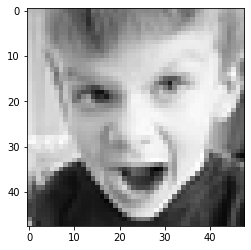

In [12]:
show_example(train_df, 107)

# Custom Dataset class to preprocess the data and send it in a suitable format

In [13]:
class expressions(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.loc[index]
        image, label = np.array([x.split() for x in self.df.loc[index, ['pixels']]]), row['emotion']
        #image = image.reshape(1,48,48)
        image = np.asarray(image).astype(np.uint8).reshape(48,48,1)
        #image = np.reshape(image,(1,48,48))
       
        
        if self.transforms:
            image = self.transforms(image)
            
        return image.clone().detach(), label
    
    


In [14]:
import torchvision.transforms as T

stats = ([0.5],[0.5])

### Train data transform and test data transform

In [15]:
train_tsfm = T.Compose([   
    T.ToPILImage(),
    T.Grayscale(num_output_channels=1),
    #T.RandomHorizontalFlip(), 
    #T.RandomRotation(10),
    T.ToTensor(), 
    T.Normalize(*stats,inplace=True), 
])
valid_tsfm = T.Compose([
    T.ToPILImage(),
    T.Grayscale(num_output_channels=1),
    T.ToTensor(), 
    T.Normalize(*stats,inplace=True)
])

In [16]:
train_ds = expressions(train_df, train_tsfm)
valid_ds = expressions(valid_df, valid_tsfm)
test_ds = expressions(test_df, valid_tsfm)

In [17]:
print(train_ds[0])

(tensor([[[-0.4510, -0.3725, -0.3569,  ..., -0.5922, -0.6627, -0.6784],
         [-0.4902, -0.5216, -0.5451,  ..., -0.5608, -0.5922, -0.6549],
         [-0.6078, -0.6627, -0.5765,  ..., -0.6157, -0.5608, -0.6314],
         ...,
         [-0.2863, -0.4902, -0.6706,  ..., -0.4353, -0.5608, -0.6627],
         [-0.3961, -0.3569, -0.3804,  ..., -0.1765, -0.4510, -0.6392],
         [-0.3961, -0.4353, -0.3412,  ..., -0.1686, -0.1451, -0.3569]]]), 0)


Lets see the type of data we have here.

In [18]:
print(train_ds[55])
print(valid_ds[55])
print(len(train_ds), len(valid_ds))

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [-0.6392, -0.6000, -0.6000,  ..., -0.6941, -0.6784, -0.4824],
         [-0.6392, -0.6235, -0.6235,  ..., -0.6863, -0.7333, -0.4902],
         [-0.6235, -0.6078, -0.6314,  ..., -0.7176, -0.7255, -0.4980]]]), 5)
(tensor([[[ 0.2863, -0.3255, -0.7098,  ...,  0.1922,  0.1608,  0.2627],
         [ 0.2627, -0.3098, -0.6235,  ...,  0.0824,  0.1294,  0.1451],
         [ 0.1529, -0.3569, -0.6314,  ..., -0.0353,  0.0902,  0.1373],
         ...,
         [-0.2000, -0.4431, -0.6784,  ..., -0.4118, -0.1529, -0.0118],
         [ 0.1294, -0.1686, -0.5922,  ..., -0.3725, -0.0745,  0.0118],
         [ 0.2235, -0.0510, -0.5843,  ..., -0.2784, -0.0275,  0.0196]]]), 3)
28709 3589


In [19]:
batch_size = 100

### Train and Test data loaders

In [20]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, 
                      num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, 
                    num_workers=2, pin_memory=True)

In [21]:
test_dl = DataLoader(test_ds, batch_size*2, 
                    num_workers=2, pin_memory=True)

### Displaying a batch of training data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


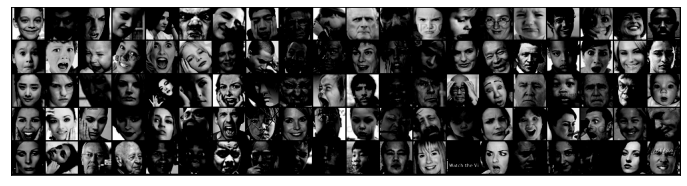

In [21]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=20).permute(1, 2, 0))
        break
        
show_batch(train_dl)

Now, Lets prepare our model!

In [22]:
import torch.nn.functional as F

In [23]:
input_size = 48*48
output_size = len(Labels)

### We are adding a residual network.

In [24]:
# evaluation metric
def accuracy(output, labels):
    predictions, preds = torch.max(output, dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))


In [25]:
# This code is used for training.(Only part of the code is present)

class expression_model(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

# Training on gpu. 
## Could also be done using CPU 


In [26]:
torch.cuda.is_available()

True

In [27]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [28]:
device = get_default_device()
device

device(type='cuda')

In [29]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [31]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [32]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x 

In [33]:
simple_resnet = to_device(SimpleResidualBlock(), device)

In [34]:
for images, labels in train_dl:
    print(images.shape)
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([100, 1, 48, 48])
torch.Size([100, 3, 48, 48])


# MODEL ARCHITECTURE

In [35]:
def conv_block(in_channels, out_channels, pool = False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace = True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


class ResNet_expression(expression_model):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64) #went from 1 to 64 channels(400*64*48*48)
        self.conv2 = conv_block(64, 128, pool=True)  # batchsize*128*24*24
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))  #residual block one(no change in num_of_channel no pooling)
        
        self.conv3 = conv_block(128, 256, pool=True)  #400*256*12*12
        self.conv4 = conv_block(256, 512, pool=True)   #400*512*6*6
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))    #400*512*6*6
        
        self.conv5 = conv_block(512, 1024, pool=True)  #400*1025*3*3
        
        self.res3 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024))    #400*1024*3*3
        
        self.classifier = nn.Sequential(nn.MaxPool2d(3), #400 * 1024 * 1 * 1
                                        nn.Flatten(), 
                                        nn.Linear(1024, num_classes)) 
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.res3(out) + out
        
        out = self.classifier(out)
        return out

In [36]:
model = to_device(ResNet_expression(1, output_size), device)
model

ResNet_expression(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(

In [37]:
# Processes that take place during training

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()   #gradient descent---> modifies the weights
            optimizer.zero_grad()   #setting gradient to zero
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()  #scheduler.step----> modifies the learning rate
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [38]:
device

device(type='cuda')

Let's verify that the model produces the expected output on a batch of training data. 

In [39]:
for images, lbl in train_dl:
    print('shape of image: ', images.shape)
    out = model(images)
    print('shape of output: ', out.shape)
    print('Output: ', out[0])
    break

shape of image:  torch.Size([100, 1, 48, 48])
shape of output:  torch.Size([100, 7])
Output:  tensor([-0.4330, -1.7845,  1.8844, -0.3787, -0.6932, -1.0064, -0.1122],
       device='cuda:0', grad_fn=<SelectBackward>)


# Trial testing the model before training

In [39]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.9458367824554443, 'val_acc': 0.24453555047512054}]

Lets train our model now. 

In [40]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

# Training

In [41]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00279, train_loss: 1.6506, val_loss: 1.7546, val_acc: 0.4328
Epoch [1], last_lr: 0.00759, train_loss: 1.5005, val_loss: 3.0151, val_acc: 0.2690
Epoch [2], last_lr: 0.01000, train_loss: 2.0900, val_loss: 1.6783, val_acc: 0.4546
Epoch [3], last_lr: 0.00950, train_loss: 1.3455, val_loss: 5.2485, val_acc: 0.3268
Epoch [4], last_lr: 0.00812, train_loss: 1.1965, val_loss: 1.5197, val_acc: 0.4204
Epoch [5], last_lr: 0.00611, train_loss: 1.2044, val_loss: 1.2683, val_acc: 0.5435
Epoch [6], last_lr: 0.00389, train_loss: 1.0172, val_loss: 1.1145, val_acc: 0.5912
Epoch [7], last_lr: 0.00188, train_loss: 0.8894, val_loss: 1.1223, val_acc: 0.5810
Epoch [8], last_lr: 0.00050, train_loss: 0.6719, val_loss: 1.0111, val_acc: 0.6414
Epoch [9], last_lr: 0.00000, train_loss: 0.4003, val_loss: 1.0625, val_acc: 0.6489
CPU times: user 5min 4s, sys: 2min 37s, total: 7min 41s
Wall time: 7min 56s


In [42]:
train_time='7:56'

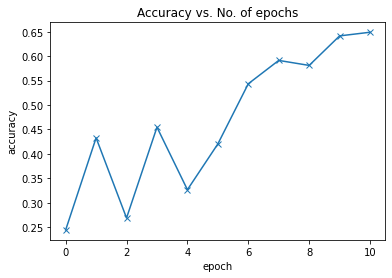

In [43]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    
plot_accuracies(history)

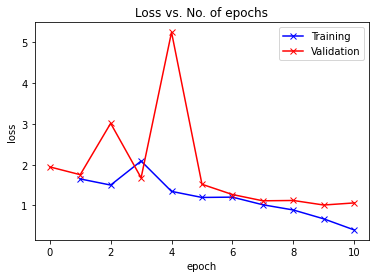

In [44]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history) 

# Saving the model

In [45]:
torch.save(model.state_dict(), '/home/praveen/Desktop/Projects/technocolab_project_2/emotion_recognition/models/resnet-facial.pth')

# Loading the model

In [40]:
model2 = to_device(ResNet_expression(1, output_size), device)


In [41]:
# Loading the weights and biases
model2.load_state_dict(torch.load('/home/praveen/Desktop/Projects/technocolab_project_2/emotion_recognition/models/resnet-facial.pth'))

<All keys matched successfully>

### TESTING on test dataset.

In [49]:
result = evaluate(model2, test_dl)
result

{'val_loss': 1.0222487449645996, 'val_acc': 0.6606348752975464}

In [47]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    print(xb)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return Labels[preds[0].item()]

tensor([[[[ 0.3333, -0.0745, -0.2078,  ..., -0.1216,  0.0275, -0.0275],
          [ 0.3176, -0.0196, -0.1529,  ..., -0.1294, -0.0275,  0.0431],
          [ 0.3569,  0.0510, -0.1137,  ..., -0.1922, -0.1059,  0.0039],
          ...,
          [-0.3569, -0.1686, -0.2235,  ...,  0.2863,  0.0353, -0.0039],
          [-0.2471, -0.1765, -0.2314,  ...,  0.2706,  0.0196,  0.0353],
          [-0.1843, -0.1922, -0.2235,  ...,  0.2471,  0.0431,  0.0275]]]],
       device='cuda:0')
Label: Angry , Predicted: Fear


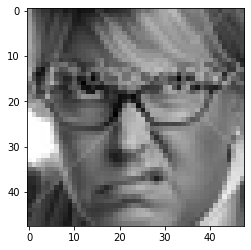

In [48]:
img, label = test_ds[0]
plt.imshow(img[0], interpolation='nearest', cmap='gray')
img = img.to(device)


print('Label:', Labels[label], ', Predicted:', predict_image(img, model2))

Label: Angry , Predicted: Angry


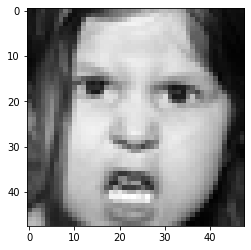

In [52]:
img, label = test_ds[110]
plt.imshow(img[0], interpolation='nearest', cmap='gray')
img = img.to(device)
print('Label:', Labels[label], ', Predicted:', predict_image(img, model2))

Label: Fear , Predicted: Fear


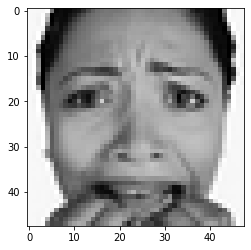

In [53]:
img, label = test_ds[500]
plt.imshow(img[0], interpolation='nearest', cmap='gray')
img = img.to(device)
print('Label:', Labels[label], ', Predicted:', predict_image(img, model2))